In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
pos = np.loadtxt('./data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt', skiprows=3)
N_real = len(pos)
pos = pos[:N_real,[1,2,3]]

In [3]:
ids = np.loadtxt('./data/pos_real.BSKIndex', dtype=int)

In [4]:
# List of connections ids
a = ids[:,0]
b = ids[:,1]

In [5]:
%%time

# Compute the number of connections and the average lenght
ID = np.zeros(N_real, dtype=int)
n_connections = np.zeros(N_real, dtype=int)
connections   = np.zeros(N_real, dtype=object)
av_length_connections = np.zeros(N_real, dtype=float)
pseudo_density = np.zeros(N_real, dtype=float)

distance_pairs =np.sum( (pos[a] - pos[b])**2, axis=1 )

pbar = tqdm(total=N_real)
for n in range(N_real):
    kx = a[b==n]
    ky = b[a==n]
    
    ID[n] = n
    n_connections[n]         = len(kx)+len(ky)
    connections[n]           = np.concatenate([kx,ky])
    av_length_connections[n] = np.sum(distance_pairs[connections[n]])/n_connections[n]
    
    # Defining the Inertial tensor from

    # TODO  remoe repeats
    Ixx = np.sum( (pos[:,1][connections[n]] - pos[:,1][n])**2  + (pos[:,2][connections[n]] - pos[:,2][n])**2 )
    Iyy = np.sum( (pos[:,2][connections[n]] - pos[:,2][n])**2  + (pos[:,0][connections[n]] - pos[:,0][n])**2 )
    Izz = np.sum( (pos[:,0][connections[n]] - pos[:,0][n])**2  + (pos[:,1][connections[n]] - pos[:,1][n])**2 )
    Ixy = np.sum( (pos[:,0][connections[n]] - pos[:,0][n])*(pos[:,1][connections[n]] - pos[:,1][n]) )  
    Iyz = np.sum( (pos[:,1][connections[n]] - pos[:,1][n])*(pos[:,2][connections[n]] - pos[:,2][n]) )
    Ixz = np.sum( (pos[:,0][connections[n]] - pos[:,0][n])*(pos[:,2][connections[n]] - pos[:,2][n]) )
    
    # Coumputing the Inertial tensor eigenvalues
    A = np.array([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz],[Ixz,Iyz,Izz]])
    eigenvalues, eigenvectors= np.linalg.eig(A)
    eigenvalues[(eigenvalues<=0)] = 0.0001
    pseudo_density[n]           = np.log( 1/( np.sqrt(eigenvalues[0]).real * np.sqrt(eigenvalues[1]).real * np.sqrt(eigenvalues[2]).real  ) )
    
    pbar.update()

  0%|          | 0/281465 [00:00<?, ?it/s]

<timed exec>:18: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 5min 5s, sys: 416 ms, total: 5min 5s
Wall time: 5min 4s


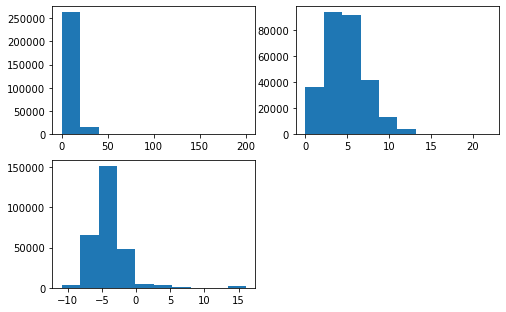

In [6]:
fig = plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
_ = plt.hist(av_length_connections)
plt.subplot(3,2,2)
_ = plt.hist(n_connections)
plt.subplot(3,2,3)
_ = plt.hist(pseudo_density)

plt.show()

In [7]:
n_connections[pseudo_density>10]

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
import src.bsk as bsk

In [9]:
%%time

Max = len(pos)

ids, nc, con = bsk.NumberConnections(Max,a,b)
ad, vol, den = bsk.Features(Max,ID,pos[:,0],pos[:,1],pos[:,2],nc,con)

/pscratch/sd/j/jfsuarez/CWCLASS/src/bsk.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ID.astype(int),Nc.astype(int),np.array(Connections)


CPU times: user 4min 46s, sys: 304 ms, total: 4min 47s
Wall time: 4min 47s


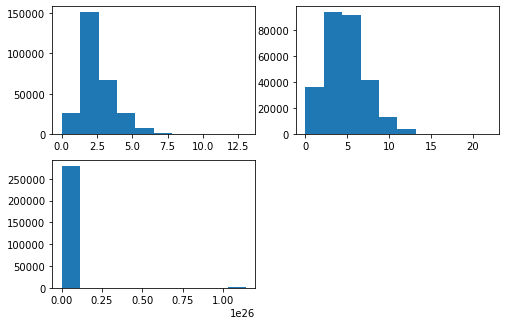

In [10]:
fig = plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
_ = plt.hist(ad)
plt.subplot(3,2,2)
_ = plt.hist(nc)
plt.subplot(3,2,3)
_ = plt.hist(den)

plt.show()

In [22]:
import h5py
import pandas as pd
f = h5py.File('../data/TNG100-1/Subhalos_Features/morphologies_deeplearn.hdf5','r')
f.keys()

<KeysViewHDF5 ['Header', 'Snapshot_95', 'Snapshot_99']>

In [14]:
f['Snapshot_99'].keys()

<KeysViewHDF5 ['P_Late', 'P_S0', 'P_Sab', 'Sigma_Late', 'Sigma_S0', 'Sigma_Sab', 'SubhaloID']>

In [31]:
morphologies_ids = f['Snapshot_99']['SubhaloID'][:]
morphologies_ids

array([     0,      1,      2, ..., 727485, 738596, 752194])

In [32]:
P_Late = f['Snapshot_99']['P_Late'][:]
P_S0 = f['Snapshot_99']['P_S0'][:]
P_Sab = f['Snapshot_99']['P_Sab'][:]
Sigma_Late = f['Snapshot_99']['Sigma_Late'][:]
Sigma_S0 = f['Snapshot_99']['Sigma_S0'][:]
Sigma_Sab = f['Snapshot_99']['Sigma_Sab'][:]

In [33]:
morphologies_df = pd.DataFrame( np.c_[morphologies_ids, P_Late, P_S0, P_Sab, Sigma_Late, Sigma_S0, Sigma_Sab], columns=['ID','P_Late','P_S0','P_Sab','Sigma_Late','Sigma_S0','Sigma_Sab'] )
morphologies_df = morphologies_df.dropna()
morphologies_df

,ID,P_Late,P_S0,P_Sab,Sigma_Late,Sigma_S0,Sigma_Sab
0,0.0,0.285813,0.581463,0.082351,0.082305,0.092707,0.054884
1,1.0,0.817303,0.041749,0.451029,0.043357,0.120770,0.033309
2,2.0,0.941455,0.156638,0.207392,0.041355,0.096414,0.057522
3,3.0,0.998825,0.015455,0.966695,0.004879,0.091223,0.043624
4,4.0,0.113466,0.022465,0.154358,0.067582,0.081769,0.058225
...,...,...,...,...,...,...,...
12530,704187.0,0.411240,0.743416,0.816058,0.053598,0.054836,0.068055
12531,719337.0,0.607696,0.462376,0.816769,0.060273,0.068407,0.065860
12532,727485.0,0.475961,0.713853,0.532344,0.034700,0.065286,0.088331
12533,738596.0,0.542526,0.795973,0.841702,0.037093,0.066633,0.024570
